In [1]:
import networkx as nx
import io
import urllib
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os
import math
import pickle
%matplotlib inline

In [62]:
# create list to hold all lengths
all_human_paths = {}

# Open file
f = io.open('./week8/wikispeedia_paths-and-graph/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited, convert to plain text
    nodes = [urllib.unquote(str(node)).decode('utf8') for node in path.split(';')]
    source = nodes[0]
    target = nodes[-1]
    
    # if the source and target are the same the game is already over!
    # errors being caused when dealing with GNU License
    if source == target or 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' in nodes:
        continue
    
    ### TRIM BACKSPACED PAGES FROM PATH ###
    backspace = '<'
    while backspace in nodes:
        # find index of first backspace
        idx_backspace = nodes.index(backspace)
        # remove back space character from path
        del nodes[idx_backspace]
        # remove backspaced page
#         del nodes[idx_backspace-1]
    
    # path[source][target] = a list of list containing nodes in path
    if source in all_human_paths:
        if target in all_human_paths[source]:
            all_human_paths[source][target].append(nodes)
        else:
            all_human_paths[source][target] = [nodes]
    else:
        all_human_paths[source] = {target: [nodes]}
    
# close file
f.close()

In [14]:
# Testing what is saved in all_human_paths
key = 'Art'
for target in all_human_paths[key].keys()[:5]:
    print key, target, all_human_paths[key][target]


0
[1, 1, 1, 3, 4, 5]
Art Byzantine_Empire [[u'Globalization', u'Mongol_Empire', u'Ottoman_Empire'], [u'Architecture', u'Ancient_Rome'], [u'Ancient_Rome']]
Art Robinson_Crusoe [[u'Literature', u'Novel']]
Art Batman [[u'Literature', u'Graphic_novel', u'Comics', u'Superman']]
Art Nature [[u'Architecture', u'Science']]
Art Mango [[u'Painting', u'Drawing', u'Computer', u'Python_(programming_language)', u'Macintosh', u'IPod', u'Hong_Kong', u'Fruit'], [u'Human', u'Herbivore', u'Fruit'], [u'Human', u'Agriculture', u'Fruit'], [u'Mind', u'Love', u'Human', u'Technology', u'Dolphin', u'Whale', u'Milk', u'Meat', u'Food', u'Famine', u'Democracy', u'Liberal_democracy', u'Property', u'John_Locke', u'Bristol', u'England', u'British_Empire', u'Football_(soccer)', u'FIFA', u'World_War_I', u'Sarajevo', u'Ottoman_Empire', u'Siege', u'Leonardo_da_Vinci', u'Horse', u'Clothing', u'Insect', u'Hymenoptera', u'Triassic', u'Biosphere', u'Ecology', u'Cell_(biology)', u'Ostrich', u'Bird', u'Reptile', u'Heat', u'Hip

In [28]:
# Open file and create graph
wikispedia_graph = nx.DiGraph()
f = io.open('./week8/wikispeedia_paths-and-graph/links.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    links = line.split('\t')
    # skip all retrieved information that is not an edge
    if len(links) != 2:
        continue
    out_node = urllib.unquote(str(links[0])).decode('utf8')
    in_node = urllib.unquote(str(links[1]).replace('\n','')).decode('utf8')
    
    wikispedia_graph.add_edge(out_node,in_node)
    
# close the file
f.close()

In [29]:
# Find paths between every node
all_shortest_paths = nx.shortest_path(wikispedia_graph)

## Create TF-IDF Dictionary

In [15]:
def tokenizer(raw):
    
    # get tokens from raw text
    tokens = nltk.word_tokenize(raw)
    
    # retrieve common stop words form nltk
    stopwords = nltk.corpus.stopwords.words('english')
    
    # isalpha returns true when no special characters and numbers are in a string
    # create stemmed list of tokens not found in remove words or when isaplha is not satisfied
    return [t.lower() for t in set(tokens) if t.lower() not in stopwords and t.isalpha()]

In [16]:
directory = './week8/plaintext_articles'
tokens = {}

try:
    print('Opening dict saved to file')
    with open('tokens.pickle', 'rb') as pickled_f:
        tokens = pickle.load(pickled_f)
        pickled_f.close()
        
except Exception as e:
    print('Creating Dict')
    for filename in os.listdir(directory):
        f = io.open(directory + '/' + filename, encoding='utf-8')
        raw = f.read()
        name = urllib.unquote(str(filename.replace('.txt',''))).decode('utf8')
        tokens[name] = tokenizer(raw)
        f.close()

    with open('tokens.pickle', 'wb') as pickled_f:
            pickle.dump(tokens, pickled_f, pickle.HIGHEST_PROTOCOL)
            pickled_f.close()

Opening dict saved to file


In [17]:
names = [name for name in tokens]

tf = {}

for name, words in tokens.iteritems():
    fd = nltk.FreqDist(words)
    tf[name] = dict(fd.items())

In [18]:
all_words = []
for name, words in tokens.iteritems():
    all_words.extend(set(words))
    
unique_words = set(all_words)

occurences = dict.fromkeys(unique_words,0.)
# total number of files
N = len(tokens.keys()) 

for word in all_words:
    occurences[word] += 1.
    
idf = {}
for word, occurence in occurences.iteritems():
    idf[word] = math.log(N / occurence,10)

In [19]:
tf_idf = {}

# get all the words for each article
for name, words in tokens.iteritems():
    
    tf_idf[name] = {}
    # for every word inside of that article calculate the idf
    for word in words:
        tf_idf[name][word] = tf[name][word] * idf[word]

## Calculate Average Similarities

In [20]:
def cosine_similarity(A,B):
    '''
    Returns the cosine similarity between 2 vectors represented as dictionaries.
    '''
    dot = 0.
    
    if len(B) < len(A):
        A, B = B, A
    
    for word, value in A.iteritems():
        dot += value * B.get(word,0)
    
    return dot / (np.linalg.norm(A.values()) * np.linalg.norm(B.values()))

In [42]:
def path_similarity(tf_idf, path):
    
    path_similarities = []
    
    # calculate the similarity between each neighboring node
    for ii in xrange(0, len(path)-1):
        # get two neighboring nodes
        node1, node2 = path[ii], path[ii+1]
        # retrieve a list of tokens with TF-IDF Values
        A, B = tf_idf[node1], tf_idf[node2]
        # calculate the similarity between the two vectors
        cos_sim = cosine_similarity(A,B)
        # save to list to calculate average similarity for path
        path_similarities.append(cos_sim)
        
    return path_similarities

### Human Similarities

In [86]:
human_similarities = []

for source, targets in all_human_paths.iteritems(): 
    
#     since the keys to the human_pairs dictionary are unique we can
#     init the dictionary here
#     human_similarities[source] = {}
    
    # for each target calculate the cosine similarity of the entire path
    for target, paths in targets.iteritems():
        
        # hold the average value of each path
        average_similarities = []
        for path in paths:
            # only consider paths greater then 2
            if len(path) > 2:
                # this list will hold the similarity of between each neighboring node
                path_similarities = path_similarity(tf_idf, path)

                # since there is multiple different paths the user can take we will save all
                # of the similarities to a single list
                average_similarities.append(np.average(path_similarities))
        
        # calculating the average similarity
        if average_similarities:
            average_similarity = np.average(average_similarities)
            human_similarities.append(average_similarity)

In [87]:
print "Average similarities stats:"
print "Mean: %f" % np.nanmean(human_similarities)
print "Variance: %f" % np.nanvar(human_similarities)
print "Min: %f" % min(human_similarities)
print "Max: %f" % max(human_similarities)

Average similarities stats:
Mean: 0.096705
Variance: 0.001034
Min: 0.011318
Max: 0.415048


In [81]:
human_similarities[:10]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

### Shortest Path Average Similarities

In [61]:
nonhuman_similarities = []

for source, targets in all_shortest_paths.iteritems(): 
    
    # for each target calculate the cosine similarity of the entire path
    for target, path in targets.iteritems():
            
#         path = nx.shortest_path(wikispedia_graph, source=source, target=target)
        # this list will hold the similarities
        path_similarities = path_similarity(tf_idf, path)
        
        # calculating the average similarity
        average_similarity = np.average(path_similarities)
        
        nonhuman_similarities.append(average_similarity)

KeyboardInterrupt: 

In [69]:
nonhuman_similarities = []

for source, targets in all_human_paths.iteritems(): 
    
    # for each target calculate the cosine similarity of the entire path
    for target in targets.keys():
            
        path = nx.shortest_path(wikispedia_graph, source=source, target=target)
        
        if len(path) > 2:
            # this list will hold the similarities
            path_similarities = path_similarity(tf_idf, path)

            # calculating the average similarity
            average_similarity = np.average(path_similarities)

            nonhuman_similarities.append(average_similarity)

In [55]:
print len(list(all_shortest_paths))
print len(list(all_human_paths))

4592
4134


In [67]:
print "Average similarities stats:"
print "Mean: %f" % np.mean(nonhuman_similarities)
print "Variance: %f" % np.var(nonhuman_similarities)
print "Min: %f" % min(nonhuman_similarities)
print "Max: %f" % max(nonhuman_similarities)

Average similarities stats:
Mean: 0.074379
Variance: 0.000791
Min: 0.011318
Max: 0.390333


### Distributions

In [38]:
def histogram(data, binwidth):
    bins = np.arange(min(data), max(data) + binwidth, binwidth)
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

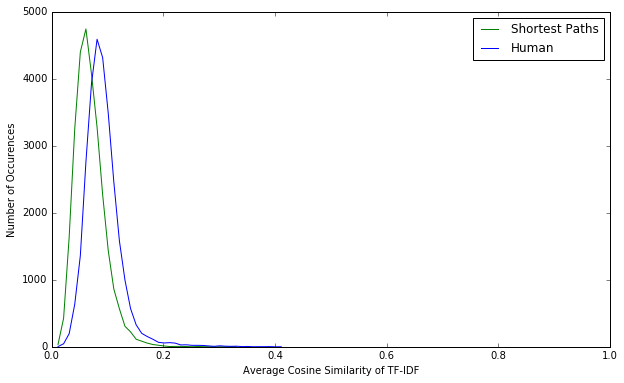

In [88]:
binwidth = 0.01

plt.figure(figsize=(10,6))

hist, bin_edges = histogram(nonhuman_similarities, binwidth)
nonhuman, = plt.plot(bin_edges[:-1], hist, 'g-')

hist, bin_edges = histogram(human_similarities, binwidth)
human, = plt.plot(bin_edges[:-1], hist, 'b-')

plt.ylabel("Number of Occurences")
plt.xlabel("Average Cosine Similarity of TF-IDF")
plt.xlim(0,1)

plt.legend([nonhuman, human], ['Shortest Paths', 'Human'])
plt.show()

In [ ]:
human_similarities = {}

for source, targets in all_human_paths.iteritems(): 
    
    # since the keys to the human_pairs dictionary are unique we can
    # init the dictionary here
    human_similarities[source] = {}
    
    # for each target calculate the cosine similarity and save the results in a dictionary
    # dict[source][target] = L where L is a list of cos_sims between the source and target tf-idf
    for target in targets:
        # tf_idf[word] = 
        cos_sim = cosine_similarity(tf_idf[source], tf_idf[target])
        # if we've already seen a source/target pair store the different cos_sim
        if target in human_similarities[source]:
            human_similarities[source][target].append(cos_sim)
        # create a new list to contain all the cos_sims of a source/target pair
        else:
            human_similarities[source][target] = [cos_sim]
        

#         # if the key already exists
#         if source in human_similarities:
#             
#         # the key does not yet exist for create a new dict mapping
#         else:
#             human_similarities[source][target] = [cos_sim]
    

# calculate the average similarity
human_average_similarities = []

# each source has multiple targets
for source, targets in human_similarities.iteritems():
    # each target has 1 or more cosine similarities
    for target, cos_sims in targets.iteritems():
        mean = np.mean(cos_sims)
        partial_sim.append(mean)
        human_average_similarities.append(mean)
        

print "Average similarities stats:"
print "Mean: %f" % np.mean(human_average_similarities)
print "Variance: %f" % np.var(human_average_similarities)
print "Min: %f" % min(human_average_similarities)
print "Max: %f" % max(human_average_similarities)

In [23]:
lst = [1,2,3]
print [5] + lst +[7]

[5, 1, 2, 3, 7]
